In [1]:
from subprocess import Popen, PIPE, STDOUT

def parse_row(row):
    elems = row.split(" ")
    return (int(elems[0]), int(elems[1]), float(elems[2]))

def run(dataset, metric):
    args = ["java", "-jar", "kotlin.jar"]
    p = Popen(args, stdout=PIPE, stdin=PIPE, stderr=STDOUT)
    input = str(len(dataset)) + " " + str(len(dataset.values[0]))
    for row in dataset.values:
        loc_inp = ""
        for i in range(len(row)):
            loc_inp += str(row[i]) + " "
        input += "\n" + loc_inp
    input += "\n" + metric
    p_stdout = p.communicate(input=bytes(input, encoding='utf-8'))[0]
    out = p_stdout.decode('utf-8').strip()
    return list(map(parse_row, out.split("\n")))

In [2]:
import numpy as np

class DSU(object):
    def __init__(self, n):
        self.n = n
        self.parents = list(range(n))
        self.rangs = np.zeros(n, dtype=int)
        self.cnt = n
        self.roots = set(list(range(n)))

    def get(self, ind):
        parent = self.parents[ind]
        if parent != ind:
            self.parents[ind] = self.get(parent)
        return self.parents[ind]

    def union(self, ind1, ind2):
        p1 = self.get(ind1)
        p2 = self.get(ind2)
        if p1 == p2:
            return

        self.cnt -= 1
        if self.rangs[p1] == self.rangs[p2]:
            self.rangs[p1] += 1

        if self.rangs[p1] < self.rangs[p2]:
            self.parents[p1] = p2
            self.roots.remove(p1)
        else:
            self.parents[p2] = p1
            self.roots.remove(p2)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA

metrics = ['Manhattan', 'Euclidean', 'Chebyshev']
d_all_colors = list(mcolors.BASE_COLORS)[:-1] + ['lightcoral', 'orchid', 'gold', 'limegreen', 'teal', 'darkblue', 'indigo',
'olive', 'tan', 'dimgray']
all_colors = d_all_colors 
all_cnt = len(metrics)

def outer_rand(dataset, dsu):
    n = len(dataset)
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    labels = list(dataset.iloc[:, -1])
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            cl_i = dsu.get(i)
            cl_j = dsu.get(j)
            ac_i = labels[i]
            ac_j = labels[j]
            cl_same = cl_i == cl_j
            ac_same = ac_i == ac_j
            if cl_same:
                if ac_same:
                    tp += 1
                else:
                    tn += 1
            else:
                if ac_same:
                    fn += 1
                else:
                    fp += 1
    print("*", end="")
    return (tp + fn) / (tp + tn + fp + fn)

def inner_dunn(dataset, dsu):
    n = len(dataset)
    data = np.array(dataset.iloc[:, :-1].values)
    m = len(data[0])
    min_d = np.array([[1e9] * n] * n)
    max_d = np.array([-1e9] * n)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            cl_i = dsu.get(i)
            cl_j = dsu.get(j)
            diff = data[i] - data[j]
            norm = np.dot(diff, diff)
            if cl_i != cl_j:
                min_d[cl_i][cl_j] = min(min_d[cl_i][cl_j], norm)
            else:
                max_d[cl_i] = max(max_d[cl_i], norm)
            
    print("+", end="")
    if max_d.max() < 1e-9:
        return 0.0
    return min_d.min() / max_d.max()

def render(fig, dsu, dataset, all_cnt, ind):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(dataset.iloc[:, :-1])
    dataset_pc = pd.DataFrame(data = principalComponents,
                              columns = ['x', 'y'])
    
    ax = fig.add_subplot(all_cnt * 2, 3, ind)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title('{} metric'.format(metrics[ind // (all_cnt * 2)]), fontsize=24, color='Gray')
    
    colors = {}
    ind1 = 0
    for root in set(dataset.iloc[:, -1]):
        colors[root] = d_all_colors[ind1]
        ind1 += 1
    
    for i in range(len(dataset)):
        color = colors[dataset.iloc[i, -1]]
        ax.scatter(dataset_pc.loc[i, 'x'], dataset_pc.loc[i, 'y'], c=color)
    ax.grid()
    
    colors = {}
    ind1 = 0
    for root in dsu.roots:
        colors[root] = all_colors[ind1]
        ind1 += 1

    ax = fig.add_subplot(all_cnt * 2, 3, ind + 1)
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title('Outer rand measure: {}\nInner rand measure: {}'.format(outer_rand(dataset, dsu), inner_dunn(dataset, dsu)), fontsize=18)
    for i in range(len(dataset)):
        color = colors[dsu.get(i)]
        ax.scatter(dataset_pc.loc[i, 'x'], dataset_pc.loc[i, 'y'], c=color)
    ax.grid()

def build_linkage_matrix(n, merge_info):
    linkage_matrix = []
    sizes = [1] * n
    remap = {}
    for i in range(n):
        remap[i] = i
    for i in range(len(merge_info)):
        ind1, ind2, dist = merge_info[i]
        sizes[ind1] += sizes[ind2]
        linkage_matrix.append([remap[ind1], remap[ind2], dist, sizes[ind1]])
        remap[ind1] = n + i
    return np.array(linkage_matrix)

def render_all(dataset, stop=0, clust_info=10, figsize=(25, 40)):
    n = len(dataset)
    fig = plt.figure(figsize=figsize)
    ind = 1
    for metric in metrics:
        merge_info = run(dataset.iloc[:, :-1], metric)
        stop_ind = -1
        max_dist_diff = -1e9
        for i in range(len(merge_info) - 1):
            if abs(merge_info[i + 1][2] - merge_info[i][2]) > max_dist_diff:
                max_dist_diff = abs(merge_info[i + 1][2] - merge_info[i][2])
                stop_ind = i

        dsu = DSU(n)
        outer_y = []
        inner_y = []
        for i in range(stop_ind + 1 - stop):
            if n - i > 1 and n - i <= clust_info:
                outer_y.append(outer_rand(dataset, dsu))
                inner_y.append(inner_dunn(dataset, dsu))
            ind1, ind2, _ = merge_info[i]
            dsu.union(ind1, ind2)
        render(fig, dsu, dataset, all_cnt, ind)
        for i in range(stop_ind + 1 - stop, n - 1):
            if n - i > 1 and n - i <= clust_info:
                outer_y.append(outer_rand(dataset, dsu))
                inner_y.append(inner_dunn(dataset, dsu))
            ind1, ind2, _ = merge_info[i]
            dsu.union(ind1, ind2)
            
        ax = fig.add_subplot(all_cnt * 2, 3, ind + 3)
        ax.plot(list(range(2, clust_info + 1)), outer_y[::-1])
        ax.set_xlabel('Clusters', fontsize=15)
        ax.set_ylabel('Rand', fontsize=15)
        
        ax = fig.add_subplot(all_cnt * 2, 3, ind + 4)
        ax.plot(list(range(2, clust_info + 1)), inner_y[::-1])
        ax.set_xlabel('Clusters', fontsize=15)
        ax.set_ylabel('Dunn', fontsize=15)
        
        ax = fig.add_subplot(all_cnt * 2, 3, ind + 2)
        linkage_matrix = build_linkage_matrix(n, merge_info)
        hierarchy.dendrogram(linkage_matrix, ax=ax, truncate_mode='lastp', p=15)
        ind += 3 * 2
        
    fig.tight_layout()

*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+*+

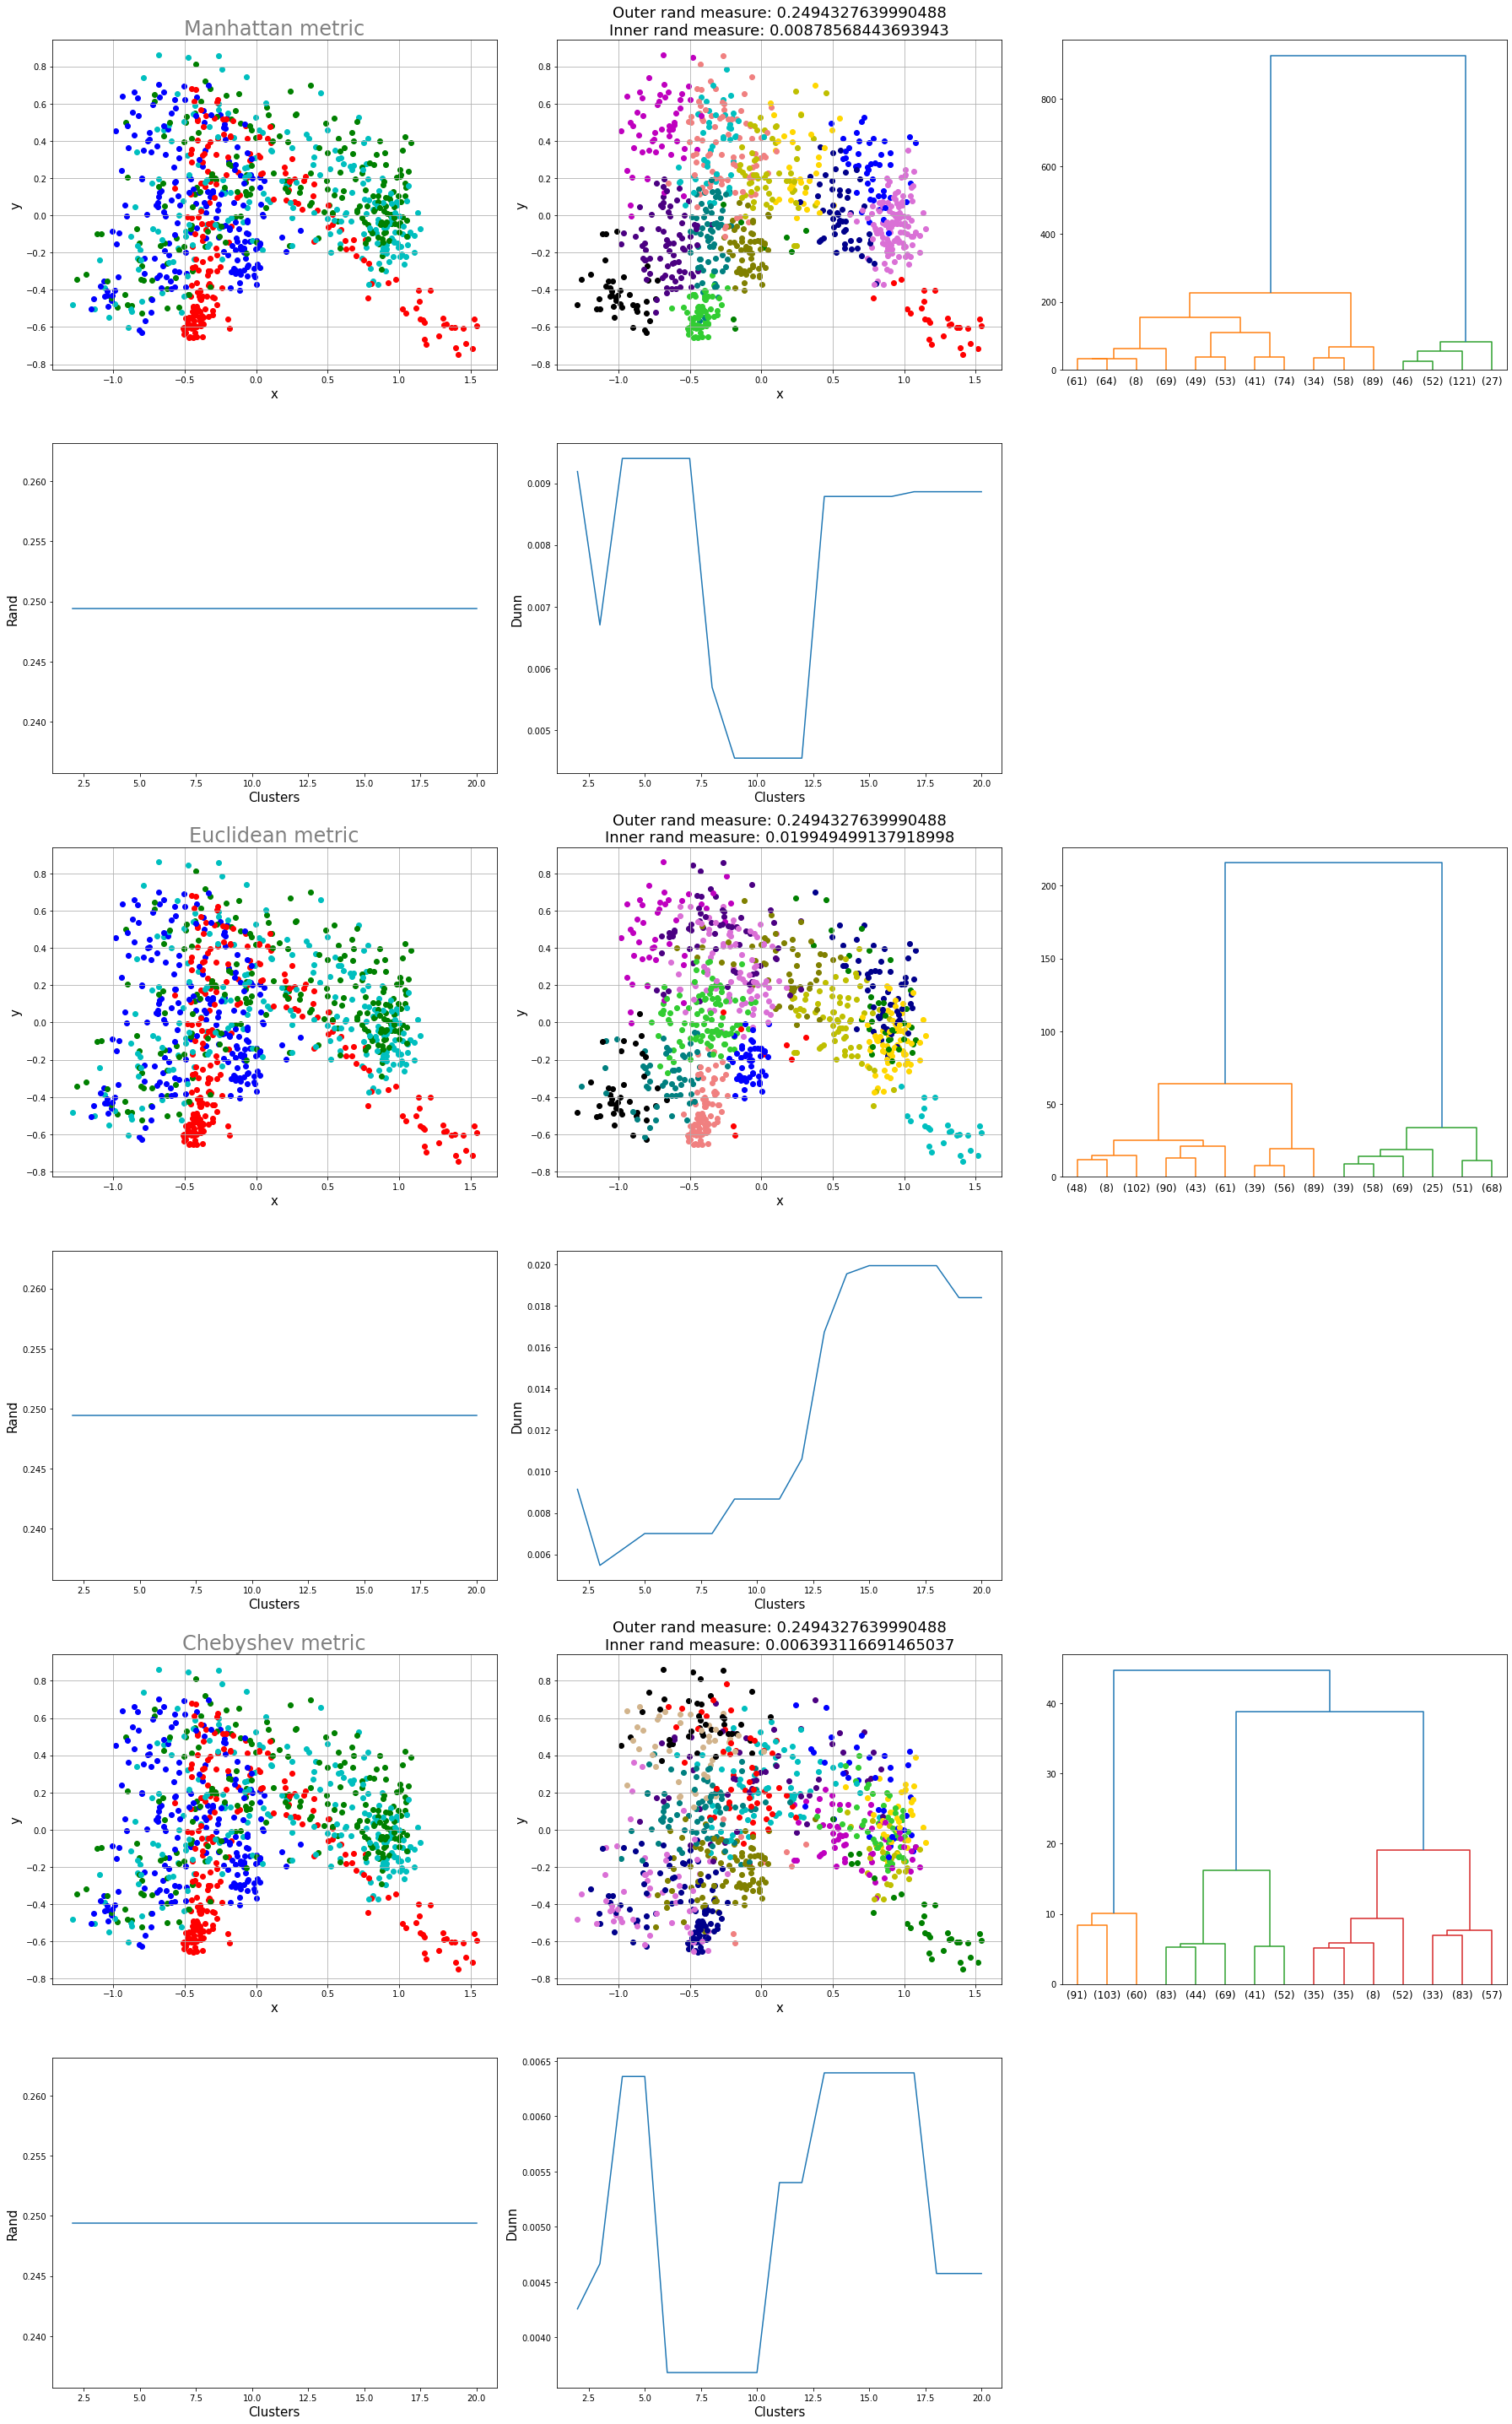

In [4]:
import pandas as pd

def minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        value_min = dataset[:, i].min()
        value_max = dataset[:, i].max()
        minmax.append([value_min, value_max])
    return minmax


def normalize(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            if i == len(row) - 1:
                continue
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
    return dataset

def factorize(dataset, features):
    for feature in features:
        dataset[feature] = pd.factorize(dataset[feature])[0]

dataset = pd.read_csv('vehicle.csv')
factorize(dataset, ['Class'])
dataset = dataset.apply(lambda x: list(map(float, x)))
min_max = minmax(dataset.values)
dataset = pd.DataFrame(normalize(dataset.values, min_max))
render_all(dataset, 13, 20)

*+

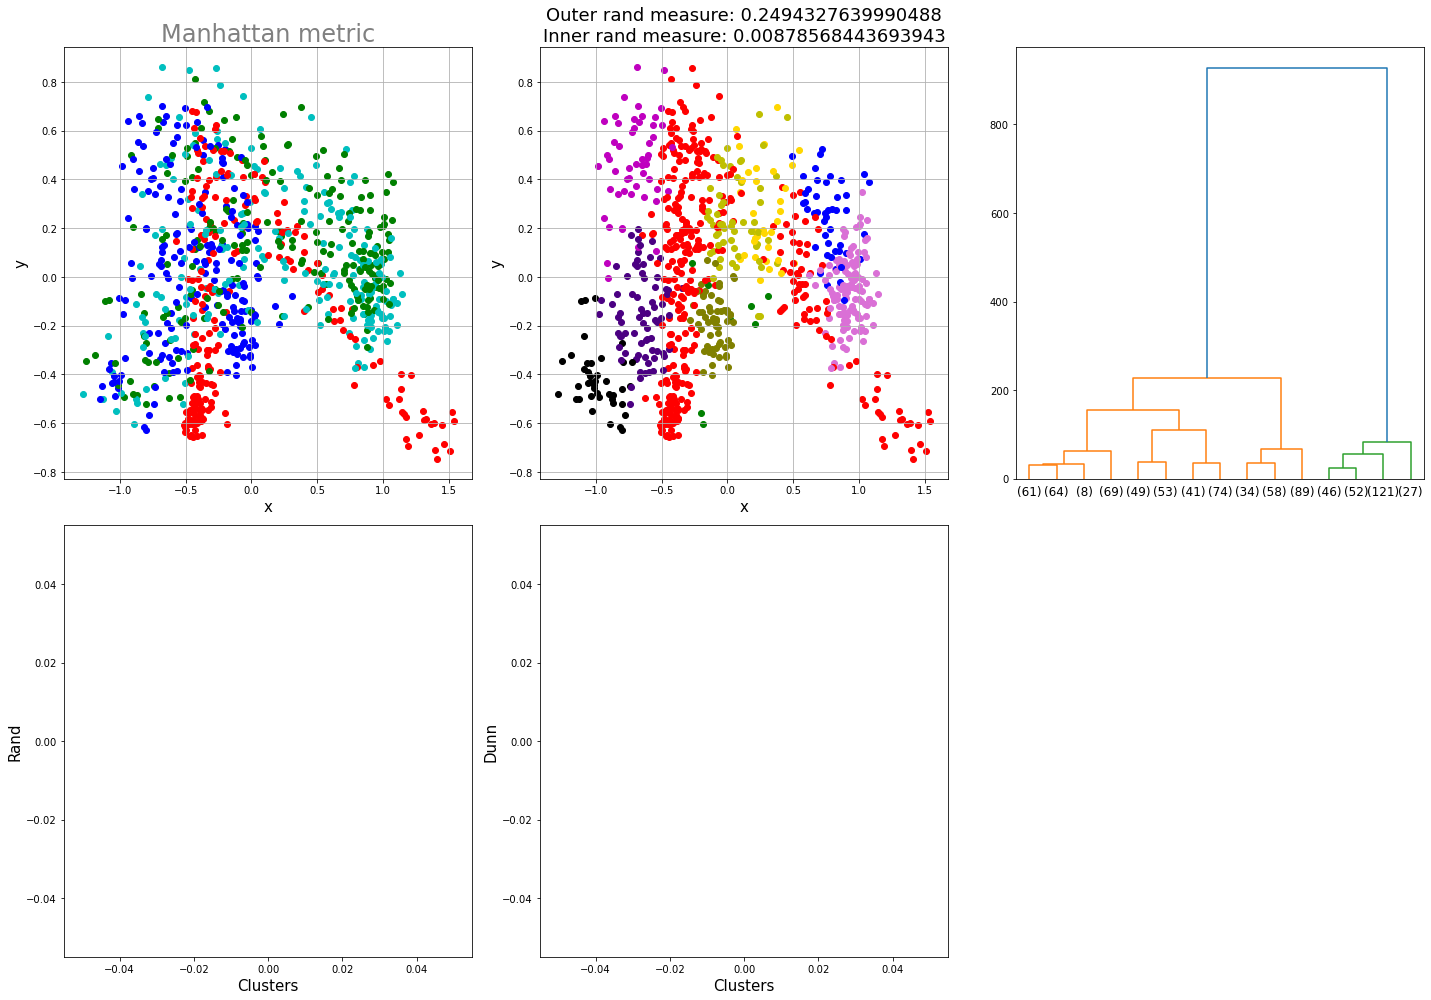

In [5]:
metrics = ['Manhattan']
all_colors = ['b', 'g', 'r', 'r', 'm', 'y', 'k', 
 'r', 'orchid', 'gold', 'r', 
 'r', 'r', 'indigo', 'olive', 'tan', 'dimgray']
all_cnt = len(metrics)
render_all(dataset, 13, 1, (20, 14))